# Training tree-based algorithms to predict epigenomic-metabolic interactions
**Author**: Scott Campit

## Mount Google Drive to Colab
This bit of code mounts Drive to the Colab notebook, and writes in an accessory function that is needed to read in Google Sheets as Pandas dataframes.

In [1]:
# Import necessary data science libraries
import pandas as pd
import numpy as np

# Load relevant libraries for Google Colab
from google.colab import auth
auth.authenticate_user()

# Allows us to read in Google Sheets via url
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

# Mount Google Drive, which will allow you to read in files within your Google 
# Drive if you wish to repurpose this for other datasets
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Accessory functions
I use this code to read in various Google sheets as Pandas dataframes. So here's a function that simplifies this operation by a lot. 

In [2]:
def read_gsheet(url='', sheetname=''):
  """
  read_gsheet reads in a Google sheet via the shared url and sheetname, and 
  outputs a pandas dataframe.

  params:
    url:       A string containing the url to the Google sheet.
    sheetname: A string containing the sheet name to be read in.
|
  return:
    df:        A Pandas dataframe of the data set.

  """
  # Read in Google sheet data
  wb = gc.open_by_url(url)
  wks = wb.worksheet(sheetname)
  data = wks.get_all_values()

  # Construct dataframe with the first row as column names
  df = pd.DataFrame(data)
  header = df.iloc[0]
  df = df[1:]
  df.columns = header
  
  return df

def save_gsheet(df, url='', sheetname=''):
  """
  save_gsheet saves a dataframe to a Google sheet using a url and a specified
  sheetname.

  :params df:        A pandas dataframe.
  :params url:       A string of the url to save the pandas dataframe data in.
  :params sheetname: A string of the sheet.
  """
  
  gc = gspread.authorize(GoogleCredentials.get_application_default())
  wb = gc.open_by_url(url)
  wb = wb.add_worksheet(title=sheetname, 
                        rows=str(df.shape[0]), 
                        cols=str(df.shape[1]))
  set_with_dataframe(wb, df)

# Load datasets
Now let's load the GCP datasets we'll be computing ratios for. Right now, we'll compute the following ratios:
  * Cancer Cell Line Encyclopedia
  * LeRoy et al., 2012

In [3]:
gcp_url = 'https://docs.google.com/spreadsheets/d/1eRwYUZve16ALg-DvwAooWPvMJfRn8j6ggUp-HVDb84A/edit?usp=sharing'
met_path = '/content/drive/My Drive/Work/Data/Metabolomics/CCLE/CCLE_ALL_Ratios.csv'

GCP = read_gsheet(url=gcp_url, sheetname='All Ratios')
MET = pd.read_csv(met_path)

print(GCP.shape)
print(MET.shape)

(866, 343)
(919, 628)


To preprocess the data, we'll do a couple of things, including:
  * Match by cell lines
  * Sort by index
  * Remove unncessary columns
  * Z-score the metabolomics data

In [4]:
idx = list(set(GCP['index']) & set(MET['index']))
GCP = GCP[GCP['index'].isin(idx)]
MET = MET[MET['index'].isin(idx)]
GCP = GCP.drop_duplicates(subset='index', keep='first')

GCP = GCP.sort_values(by=['index'])
MET = MET.sort_values(by=['index'])
print(GCP.shape)
print(MET.shape)

(858, 343)
(858, 628)


In [5]:
cell_lines = GCP['index'].values
gcpcol_to_drop = ['index'] 
metcol_to_drop = ['index', 'Unnamed: 0', 'Cell Lines']

GCP = GCP.drop(labels=gcpcol_to_drop, axis=1)
MET = MET.drop(labels=metcol_to_drop, axis=1)
print(GCP.shape)
print(MET.shape)


(858, 342)
(858, 625)


Save the column names, which will be used later when constructing dataframes for evaluating model performance.

metabolites = list(MET.columns)
gcps = list(GCP.columns)

In [6]:
from sklearn.preprocessing import quantile_transform
from sklearn.preprocessing import robust_scale
from scipy.stats import zscore
GCP_norm = GCP
MET_norm = zscore(MET, axis=1)

# SANITY CHECK: Plot the data distributions for the metabolites and histone ratios

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


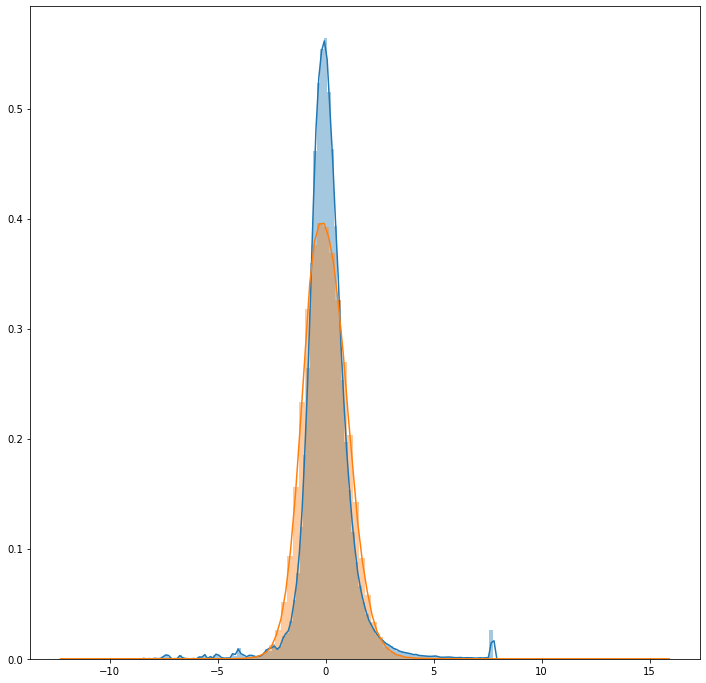

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 12))
sns.distplot(GCP, bins=100)
sns.distplot(MET_norm, bins=100)

# Cancer cell line encyclopedia GCP -> Metabolism models
First, let's split the data into training and test sets.

In [8]:
from sklearn.model_selection import train_test_split

Convert to Numpy array.

In [9]:
GCP_norm = GCP_norm.to_numpy()

Split the data into validation and training data.

In [10]:
# Split the CCLE data into a validation set
Xtrain, Xval, Ytrain, Yval = train_test_split(
    GCP_norm, MET_norm, test_size=0.3, random_state=0
)

Print shape of $X_{train}$ and $Y_{train}$.

In [11]:
print(GCP_norm.shape)
print(MET_norm.shape)
print(Xtrain.shape)
print(Ytrain.shape)
print(Xval.shape)
print(Yval.shape)

(858, 342)
(858, 625)
(600, 342)
(600, 625)
(258, 342)
(258, 625)


In [39]:
print(np.sum(Xtrain == np.inf))
print(np.sum(Xtrain == -np.inf))
print(np.sum(Xtrain == np.NaN))
print(np.sum(Ytrain == np.inf))
print(np.sum(Ytrain == -np.inf))
print(np.sum(Ytrain == np.NaN))

0
0
0
0
0
0


## 3-fold cross validation for non-linear regressor selection
Now let's train a bunch of non-linear regressors and evaluate their performance.

We'll train the following ML models:
  * Random Forests
  * Gradient boosting
  * Gaussian Process Regression
  * XGBoost


In [28]:
# ML models
!pip install scikit-optimize
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
#from sklearn.ensemble import GaussianProcessRegressor
from sklearn.ensemble import ExtraTreesRegressor

# XGBoost
!pip install xgboost
import xgboost as xgb

# Accessory functions
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# Suppress annoying warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from joblib import Parallel, delayed
from skopt import dump, load
from skopt.utils import use_named_args

### Load some hyperparameters to sample

Let's define the search parameters we'll use for hyperparameter optimization

In [43]:
# Gradient boosting
gb_params = {
    'max_depth': Integer(1, 5),
    'max_features': Categorical(['auto', 'sqrt', 'log2']),
    'min_samples_split': Integer(2, 100),
    'min_samples_leaf': Integer(1, 100),
    'learning_rate': Real(10**-5, 10**0, "log-uniform")
}

# Random Forests
rf_params = {
    'max_depth': Integer(1, 5),
    'max_features': Integer(1, Xtrain.shape[1]-1),
    'min_samples_split': Integer(2, 100),
    'min_samples_leaf': Integer(1, 100)
}

# Extra Trees
et_params = {
    'max_depth': Integer(1, 5),
    'max_features': Integer(1, Xtrain.shape[1]-1),
    'min_samples_split': Integer(2, 100),
    'min_samples_leaf': Integer(1, 100),
}

# XGBoost
xgb_params ={
    'gamma': Integer(1, 10),
    'learning_rate': Real(10**-5, 0.99, prior="log-uniform"),
    'max_depth': Integer(3, 10),
    'reg_alpha': Real(10**-5, 1, prior="log-uniform"),
    'reg_lambda':Real(10**-5, 1, prior="log-uniform"),
    'max_delta_step': Integer(0, 10),
}

### Random forest regression 

The following line below performs Bayesian hyperparameter optimization using a random forest regressor. By default, 3-fold cross validation is used

In [ ]:
from sklearn.model_selection import KFold

# Set the kfold operator to split 3 times with shuffle
kfold = KFold(n_splits=3, 
              shuffle=True, 
              random_state=0)

# Set the bayesian hyperparameter tuning to also include kfold cross validation
opt1 = BayesSearchCV(
    estimator=RandomForestRegressor(),
    search_spaces=rf_params,
    n_iter=30,
    n_jobs=4,
    cv=kfold,
    random_state=0
)

# Construct univariate random forest models and append to mdls list
mdls = []
for i in range(Ytrain.shape[1]):
  _ = opt1.fit(Xtrain, Ytrain)
  mdls.append(opt1)

/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packa

### Save RF GCP -> MET model 
Ensure model persistence by saving the serialized version of the model

In [ ]:
model_path='/content/drive/My Drive/Work/Analysis/eGEMM/ML/Nonlinear models/GCP2MET/rf.pkl'
dump(mdls, model_path)

### Gradient boosting
Now let's train the remaining GCP -> MET models and save them as well.


In [33]:
# Gradient Boosting
opt2 = BayesSearchCV(
    estimator=GradientBoostingRegressor(),
    search_spaces=gb_params,
    n_iter=30,
    n_jobs=4,
    cv=kfold,
    random_state=0
)

mdls = []
for i in range(Ytrain.shape[1]):
  _ = opt2.fit(Xtrain, Ytrain)
  mdls.append(opt2)
model_path='/content/drive/My Drive/Work/Analysis/eGEMM/ML/Nonlinear models/GCP2MET/gb.pkl'
dump(mdls, model_path)

ValueError: ignored

### Extra Trees
Same for the extra trees -> train them and save them.

In [21]:
# Extra Trees
opt3 = BayesSearchCV(
    estimator=ExtraTreesRegressor(),
    search_spaces=et_params,
    n_iter=30,
    n_jobs=4,
    cv=kfold,
    random_state=0
)

mdls = []
for i in range(Ytrain.shape[1]):
  _ = opt3.fit(Xtrain, Ytrain)
  mdls.append(opt3)
model_path='/content/drive/My Drive/Work/Analysis/eGEMM/ML/Nonlinear models/GCP2MET/et.pkl'
dump(mdls, model_path)

### XGBoost
Same for gradient boosting -> train them and save them.

In [42]:
# Create object that will perform Bayesian hyperparameter tuning with 30 different iterations
opt4 = BayesSearchCV(
    estimator=xgb.XGBRegressor(),
    search_spaces=xgb_params,
    n_iter=30,
    cv=kfold,
    random_state=0
)

# Create an object that will store all models
mdls = []
for i in range(Ytrain.shape[1]):
  _ = opt4.fit(Xtrain, Ytrain[:, i])
  mdls.append(opt4)
model_path='/content/drive/My Drive/Work/Analysis/eGEMM/ML/Nonlinear models/GCP2MET/xgb.pkl'
dump(mdls, model_path)

[18:23:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:23:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:23:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:23:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:23:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:23:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:23:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:23:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[18:32:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[18:40:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:40:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:40:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:40:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:40:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:40:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:40:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:40:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


[18:47:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:47:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:47:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:47:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:47:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:47:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:47:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:47:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

KeyboardInterrupt: ignored

# Cancer cell line encyclopedia Metabolism -> GCP models
Now we'll try to learn models that do the reverse problem: predicting chromatin profiles using metabolic data.

Now that I have some sense on how to write up K-fold cross validation with hyperparameter tuning, I'll create a function that does all of the bits above.

In [ ]:
# Split the CCLE data into a validation set
Xtrain, Xval, Ytrain, Yval = train_test_split(
    MET_norm, GCP_norm, test_size=0.3, random_state=0
)

models = [
          RandomForestRegressor(),
          GradientBoostingRegressor(),
          ExtraTreesRegressor(),
          xgb.XGBRegressor()
]

params = [
          gb_params,
          rf_params,
          et_params,
          xgb_params
]
names = [
         '/content/drive/My Drive/Work/Analysis/eGEMM/ML/Nonlinear models/MET2GCP/rf.pkl',
         '/content/drive/My Drive/Work/Analysis/eGEMM/ML/Nonlinear models/MET2GCP/gb.pkl',
         '/content/drive/My Drive/Work/Analysis/eGEMM/ML/Nonlinear models/MET2GCP/et.pkl',
         '/content/drive/My Drive/Work/Analysis/eGEMM/ML/Nonlinear models/MET2GCP/xgb.pkl'
]

Here is the function that I have defined in order to do the following steps for each model:
  1. Define the BayesOpt object.
  2. Compute a model for each feature.
  3. Save all models based on a designated path.

In [ ]:
def train_models(models, params, Xtrain, Ytrain, kfold, filename):
  """
  train_models performs kfold bayesian hyperparameter tuning for different 
  models, and saves the output for model persistence.

  :param models: A single sklearn model object or list of sklearn model objects.
  :param params: A dictionary or list of dictionaries containing hyperparameters 
                 to tune.
  :param Xtrain: A numpy array or pandas dataframe containing the training data.
  :param Ytrain: A numpy array or pandas dataframe containing the output data.
  :param kfold:  An integer or sklearn object determining the kfold operation 
                 performed.
  :param filename: A string or list of paths to save the models (pickle).

  """
  for i in range(len(models)):
    opt = BayesSearchCV(
                          estimator=models[i],
                          search_spaces=params[i],
                          n_iter=30,
                          cv=kfold,
                          random_state=0
    )

    mdls =[]
    for j in range(Ytrain.shape[1]):
      _ = opt.fit(Xtrain, Ytrain[:, j])
      mdls.append(opt)

    model_path = filename[i]
    dump(mdls, model_path)

Finally, let's train the models.

In [ ]:
train_models(models, params, Xtrain, Ytrain, kfold, names)

# Evaluating the models

## GCP to MET models
Now that I have some models trained up, it's time to create some data structures that will have the metrics I want. First, let's grab the validatoin set again from the `train_test_split()` function. Because the seed is set, it should get me the same entries.

In [ ]:
# Split the CCLE data into a validation set
Xtrain, Xval, Ytrain, Yval = train_test_split(
    GCP_norm, MET_norm, test_size=0.3, random_state=0
)

Next, we'll load some libraries we'll be using to evaluate the predicted value against the true value.

In [ ]:
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

Let's now load the models we have trained to predict metabolite values from chromatin profiles.

In [ ]:
mdls = [load('/content/drive/My Drive/Work/Analysis/eGEMM/ML/Nonlinear models/GCP2MET/rf.pkl'),
        load('/content/drive/My Drive/Work/Analysis/eGEMM/ML/Nonlinear models/GCP2MET/gb.pkl'),
        load('/content/drive/My Drive/Work/Analysis/eGEMM/ML/Nonlinear models/GCP2MET/et.pkl'),
        load('/content/drive/My Drive/Work/Analysis/eGEMM/ML/Nonlinear models/GCP2MET/xgb.pkl')
]

The `evaluate_models()` function will compute evaluation metrics and spit out the final metrics of interest.

In [ ]:
def evaluate_models(models, Xval, Yval):
  """
  evaluate_models returns metrics from the model predictions, include the pearson
  correlation coefficient, coefficient of determination, MSE, and MAE.

  :param models:         A scikit-learn model object or list of model objects.
  :param Xval:           A numpy array or pandas dataframe containing 
                         validation set input data.
  :param Yval:           A numpy array or pandas dataframe containing 
                         validation set output data.
  :return final_metrics: A pandas dataframe or list of dfs containing the final 
                         evaluation metrics
  """

  final_metrics = []
  for j = 1 in range(len(models)):
    # Iterate through model objects
    m = models[j]

    r_values = list()
    p_values = list()
    mse_values = list()
    mae_values = list()

    # Iterate through features
    for i in range(len(m)):
      mdl = m[i]
      ypred = mdl.predict(Xval)
      r, pvalue = pearsonr(ypred, Yval[:, i])
      mse = mean_squared_error(ypred, Yval[:, i])
      mae = mean_absolute_error(ypred, Yval[:, i])

      r_values.append(r)
      p_values.append(pvalue)
      mae.append(mae)
      mse.append(mse)

    # Save the metrics in a dataframe
    pre_df = {
              "Pearson": r_values, 
              "Pvalue":  p_values,
              "MSE":     mse,
              "MAE":     mae
              }
    df = pd.DataFrame(pre_df)
    final_metrics.append(df)

    return final_metrics

Let's run the function on the list of regressors I have trained. Then we'll perform the following operations:

  1. Concatenate the results into a single dataframe
  2. Append the metabolite names to the list
  3. Sort the values in ascending alphabetical order by metabolite name
  4. Save the final results to the Google Sheet.

In [ ]:
final_metrics = evaluate_models(mdls, Xval, Yval)

# Flatten the array so that 
final_metrics = pd.concat(final_metrics, axis=1)
final_metrics["Metabolites"] = metabolites
final_metrics = final_metrics.sort_values(by=["Metabolites"], 
                                          axis=1, 
                                          ascending=True)


url = 'https://docs.google.com/spreadsheets/d/1_tFjeBplSfozCw0VIU84j8d0NTm4CyOAFr9tXQfBLoE/edit?usp=sharing'
sheetname = 'GCP2Met_Ratios_Nonlinear'

save_gsheet(final_metrics, url, sheetname)

## MET to GCP models
Now let's do the reverse using the same operations described above.

In [ ]:
# Split the CCLE data into a validation set
Xtrain, Xval, Ytrain, Yval = train_test_split(
    MET_norm, GCP_norm, test_size=0.3, random_state=0
)

mdls = [load('/content/drive/My Drive/Work/Analysis/eGEMM/ML/Nonlinear models/MET2GCP/rf.pkl'),
        load('/content/drive/My Drive/Work/Analysis/eGEMM/ML/Nonlinear models/MET2GCP/gb.pkl'),
        load('/content/drive/My Drive/Work/Analysis/eGEMM/ML/Nonlinear models/MET2GCP/et.pkl'),
        load('/content/drive/My Drive/Work/Analysis/eGEMM/ML/Nonlinear models/MET2GCP/xgb.pkl')
]

final_metrics = evaluate_models(mdls, Xval, Yval)

# Flatten the array so that 
final_metrics = pd.concat(final_metrics, axis=1)
final_metrics["GCP"] = gcps
final_metrics = final_metrics.sort_values(by=["GCP"], 
                                          axis=1, 
                                          ascending=True)

url = 'https://docs.google.com/spreadsheets/d/1_tFjeBplSfozCw0VIU84j8d0NTm4CyOAFr9tXQfBLoE/edit?usp=sharing'
sheetname = 'Met2GCP_Ratios_Nonlinear'

save_gsheet(final_metrics, url, sheetname)